In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
from matplotlib import pyplot as plt
#import dvu
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import viz
import numpy as np
#import torch
import scipy
from matplotlib import pyplot as plt
from sklearn import metrics
import data
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
import outcomes
import neural_networks
from sklearn.model_selection import KFold
#from torch import nn, optim
#from torch.nn import functional as F
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.svm import SVR
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# compare all different models across dsets

In [1]:
!ls ../reports

accuracy_stability_dark.png
accuracy_stability.pdf
auc_roc_stability.png
cell_level_res_2.csv
cell_level_res.csv
cell_level_res.pickle
cell_level_res_successful.csv
cell_level_res_successful_dynamin.csv
cell_level_res_successful_full.csv
dasc_lstm_correlation_scatter.pdf
dasc_lstm_scatter_dark.png
dasc_lstm_scatter.pdf
dataset_level_hyperparameter_stability.csv
dataset_level_hyperparameter_stability_tuning.csv
dataset_level_res_2.csv
dataset_level_res.csv
dataset_level_res_successful.csv
dataset_level_res_successful_dynamin.csv
dataset_level_res_successful_full.csv
data_size_stability_10_dasc_acc.pkl
data_size_stability_10.pkl
data_size_stability_10_successful_full.pkl
data_size_stability.pkl
events_label_correction
figs
full_data_results.ipynb
gb_basic_lstm_scatter_dark.png
gb_lstm_scatter.pdf
num_tracks_by_cell.pkl
readme.md


In [14]:
suffix = '_successful_full' # '_successful', _successful_dynamin, _successful_full # '' choose which outcome to use

In [5]:
res = pd.read_csv(f"../reports/dataset_level_res{suffix}.csv", index_col=0)

In [15]:
res = pd.read_csv(f"../reports/dataset_level_res{suffix}.csv", index_col=0)
res = res.round(3)
# res = res[[c for c in res.columns if 'balanced' not in c]]
# print(res)
res = res.transpose()
res = res[['gb_basic', 'rf_basic', 'svm_basic', 'svm_dasc', 'lstm']]
num_cells = pkl.load(open("../reports/num_tracks_by_cell.pkl", "rb"))
# res.to_latex()

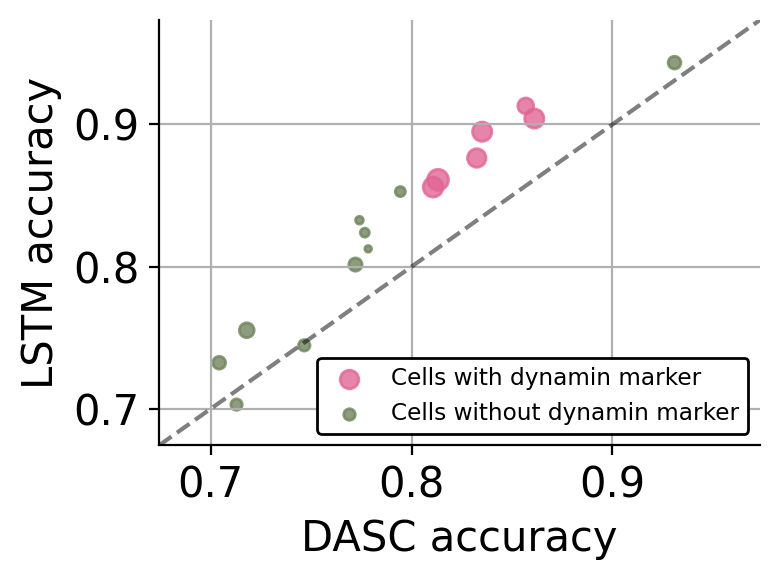

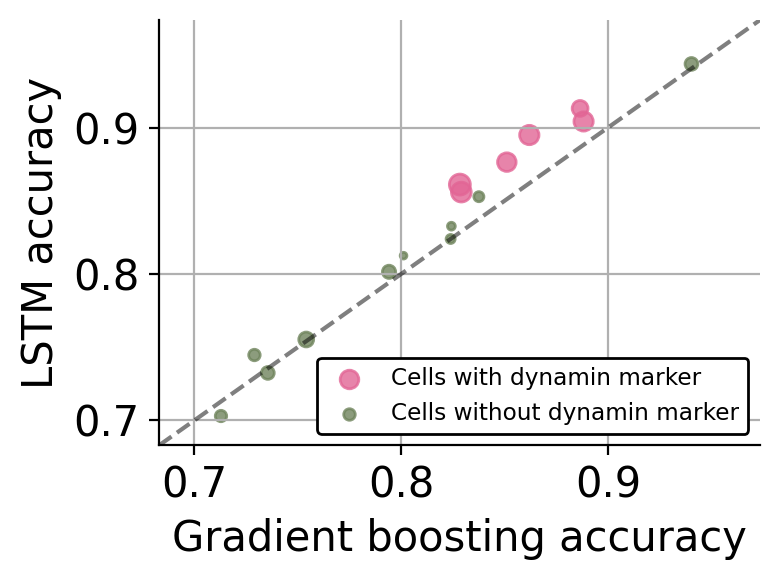

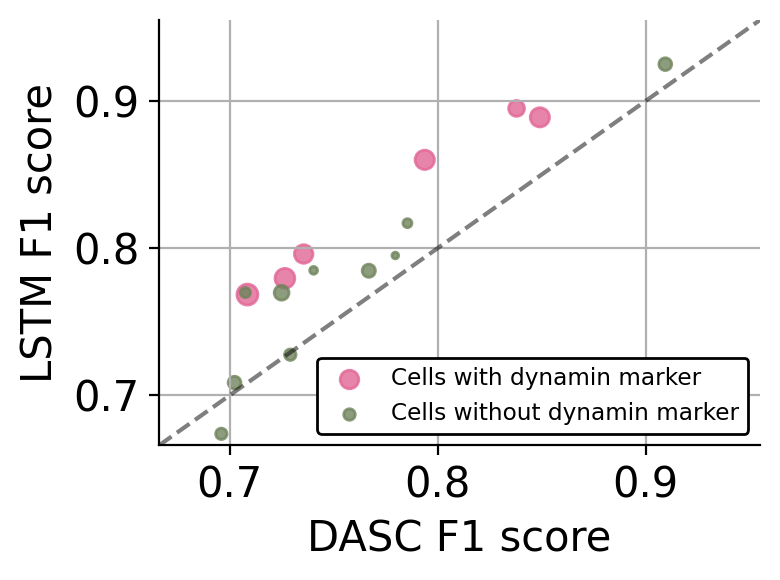

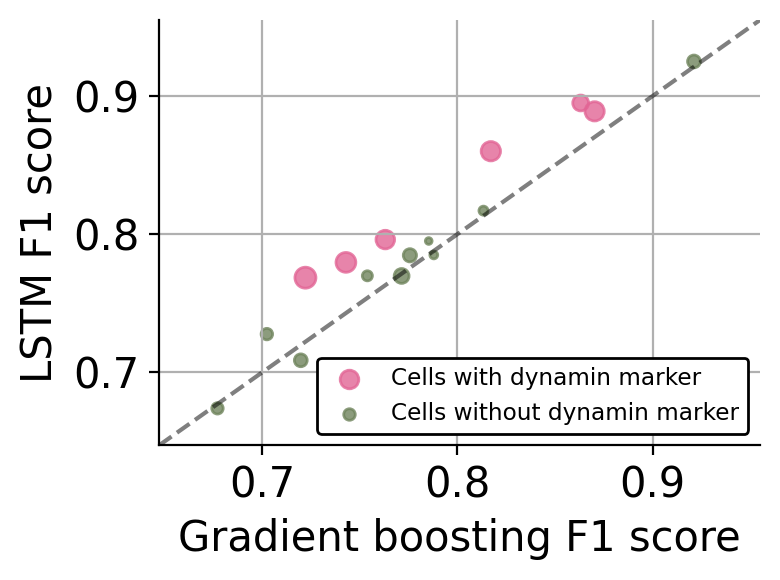

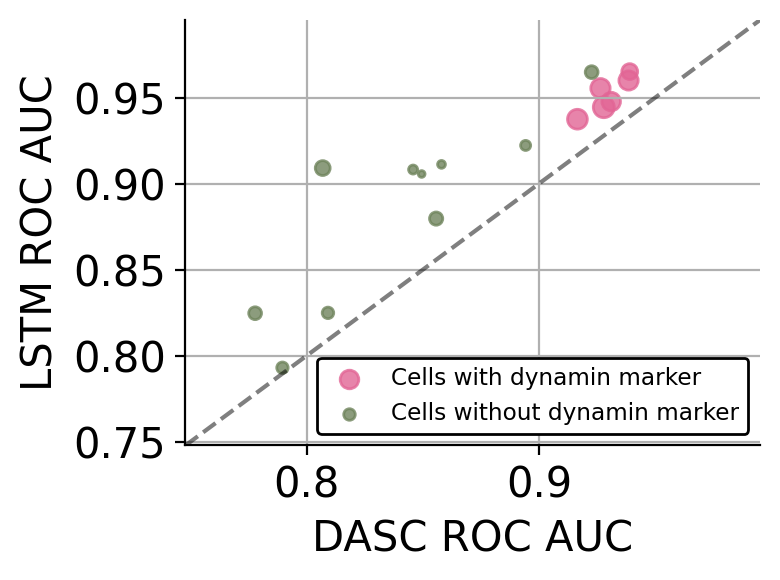

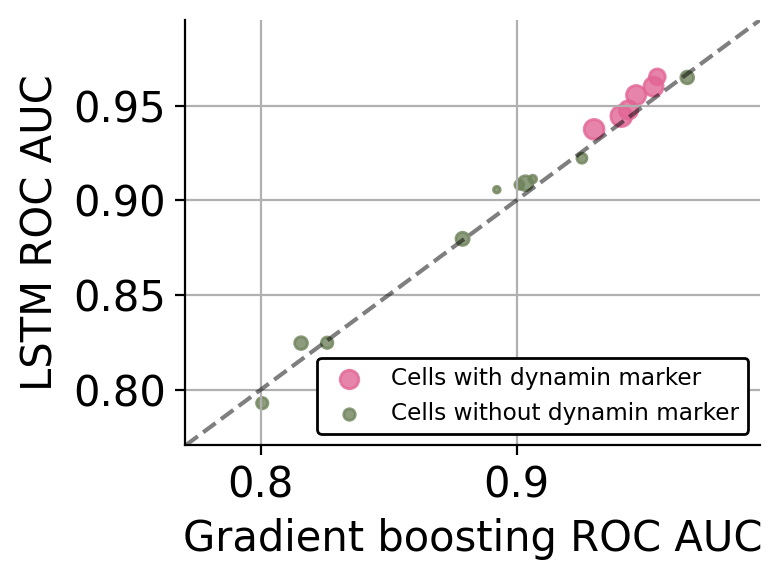

In [27]:
res = pd.read_csv(f"../reports/cell_level_res{suffix}.csv", index_col=0)
plot_label = {"accuracy": "accuracy", "f1": "F1 score", "roc_auc": "ROC AUC"}
res = res[[c for c in res.columns if not 'balanced' in c]]
for metric in ['accuracy', 'f1', 'roc_auc']:
    res_metric = res[[c for c in res.columns if metric in c]]
    # res = res[[c for c in res.columns if c.endswith('accuracy') and not 'balanced' in c]]
    dynamin_cells = [f'{k}_{metric}' for k in config.DSETS['clath_aux_dynamin']['test']]
    non_dynamin_cells = [c for c in res_metric.columns if c not in dynamin_cells]
    baseline = 'svm_dasc'
    for baseline in ['svm_dasc', 'gb_basic']:

        plt.figure(dpi=200, figsize=(4, 3))
        plt.grid(zorder=-1.0)
        plt.scatter(res.loc[baseline][dynamin_cells].values, 
                    res.loc['lstm'][dynamin_cells].values, 
                    color='#E26595',
                    s=[1. * num_cells[cell[:-(len(metric) + 1)]]/30 for cell in dynamin_cells], 
                    label='Cells with dynamin marker',
                    alpha=.8)
        plt.scatter(res.loc[baseline][non_dynamin_cells].values, 
                    res.loc['lstm'][non_dynamin_cells].values, 
                    color='#6F845C',
                    s=[1. * num_cells[cell[:-(len(metric) + 1)]]/30 for cell in non_dynamin_cells], 
                    label='Cells without dynamin marker',
                    alpha=.8)
        
        lowerlim = min(res_metric.loc[baseline][non_dynamin_cells].values) - 0.03
        upperlim = max(res_metric.loc['lstm'].values) + 0.03
        plt.xlim((lowerlim, upperlim))
        plt.ylim((lowerlim, upperlim))
        if baseline == 'svm_dasc':
            plt.xlabel(f"DASC {plot_label[metric]}")
        else:
            plt.xlabel(f"Gradient boosting {plot_label[metric]}")
        plt.ylabel(f"LSTM {plot_label[metric]}")
        plt.legend(loc='lower right', fontsize='small', framealpha=1, edgecolor='black')
        plt.plot((lowerlim, upperlim), (lowerlim, upperlim), '--', color='k', alpha=.5)
        viz.savefig(f'lstm_{baseline}_{metric}')
        plt.show()